# Can Precision Manufacturing Move Beyond Reactive Maintenance?
A Data-Driven Investigation into Machine Downtime Patterns

![Machine Downtime](image.png)

Image from [H.O.Penn](https://www.hopenn.com/blog/what-to-do-when-your-equipment-breaks-down/)

**Creator Notes:**
- Use `light` mode view for optimal reading.
- Plots are interactive, allowing you to explore the data in detail.

# Executive Summary

This analysis provides clear targets for maintenance optimization and downtime reduction, with specific focus areas identified for immediate intervention.

**Timeline Analysis**
* First reading: November 24, 2021 (Wednesday)
* Last reading: July 3, 2022 (Sunday)
* Critical period: March 2022 showed highest failure concentration
* Pattern: Mid-week periods consistently record more failures

**Torque Performance**
* Mean value: 25.23 Nm (critical operational threshold)
* Two distinct operating ranges identified:
  - Lower cluster: 13-19 Nm
  - Higher cluster: 23-30 Nm
* Mean value acts as transition point where failures frequently occur

**Assembly Line Performan**ce
* Shopfloor-L1: 454 failures (51.95% downtime)
* Shopfloor-L2: 396 failures (49.01% downtime)
* Shopfloor-L3: 415 failures (50.73% downtime)
* Critical gap: 58 more failures in L1 versus L2

**Key Insights**
* All assembly lines show concerning failure rates around 50%
* Mid-week operations face higher risk of machine failures
* Torque transitions through 25.23 Nm represent critical failure points
* March 2022 requires particular attention in maintenance planning
* Shopfloor-L1 maintenance practices need immediate review

**Immediate Actions Required**
* Implement torque monitoring at identified critical ranges
* Review March production schedules and maintenance timing
* Standardize maintenance procedures across all assembly lines



## I. Background

In the precision manufacturing sector, where components must meet exacting standards for aerospace, automotive, and medical applications, machine reliability directly impacts product quality and delivery schedules. A leading manufacturer operates three specialized machines, each dedicated to producing components of different sizes. These machines represent the backbone of the production line, where every minute of downtime translates to delayed shipments and potential revenue loss.

The traditional approach to machine maintenance has been reactive — waiting for failures to occur before taking action. This method leads to unpredictable production schedules, rushed repairs, and increased maintenance costs. To address these challenges, the company implemented a comprehensive data collection system over a year ago, recording various operational parameters that might indicate potential machine failures.

## II. Objectives
This analysis examines operational data from three manufacturing assembly lines producing precision components for aerospace, automotive, and medical applications. The core focus is **understanding machine downtime patterns to enable proactive maintenance planning.**

It aims to: 
- Establish the complete timeline of machine monitoring
- Analyze average torque values and operating ranges
- Identify the most problematic assembly line based on downtime frequency

## III. The data

The operational data contains detailed measurements from each machine, recorded daily:

| Column Name | Description | Unit | Significance |
|------------|-------------|------|--------------|
| Date | Daily timestamp of readings | YYYY-MM-DD | Tracks temporal patterns and maintenance history |
| Machine_ID | Unique machine identifier | Text | Enables machine-specific analysis and comparisons |
| Assembly_Line_No | Production line location | Integer | Maps physical layout and workflow dependencies |
| Hydraulic_Pressure | Hydraulic system pressure | bar | Indicates fluid power system health |
| Coolant_Pressure | Cooling system pressure | bar | Monitors heat dissipation efficiency |
| Air_System_Pressure | Pneumatic system pressure | bar | Reflects compressed air system status |
| Coolant_Temperature | Cooling system temperature | Celsius | Tracks thermal management effectiveness |
| Hydraulic_Oil_Temperature | Hydraulic fluid temperature | Celsius | Indicates system stress and oil condition |
| Spindle_Bearing_Temperature | Bearing temperature | Celsius | Monitors critical component health |
| Spindle_Vibration | Spindle oscillation | micrometers | Detects mechanical imbalances |
| Tool_Vibration | Cutting tool movement | micrometers | Indicates tool wear and stability |
| Spindle_Speed | Rotational velocity | RPM | Measures cutting performance |
| Voltage | Electrical input | volts | Monitors power supply stability |
| Torque | Rotational force | Nm | Indicates mechanical load |
| Cutting | Tool force | KN | Measures material removal effort |
| Downtime | Operational status | Boolean | Records machine availability |

The company has stored the machine operating data in a single table, available in `'data/machine_downtime.csv'`.

In [212]:
# Install necessary packages
!pip install plotly-calplot
!pip install exploralytics

# Import essential libraries for data manipulation and visualization
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

# Import library for visualizing missing data
import matplotlib.pyplot as plt
import missingno as msno 

# Import specific visualization tools
from exploralytics.visualize import Visualizer
from plotly_calplot import calplot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [204]:
# Load the dataset and display the first 10 rows
data = pd.read_csv('data/machine_downtime.csv')
display(data.head(10))

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,71.040000,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,125.330000,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,31-12-2021,Makino-L3-Unit1-2015,Shopfloor-L3,71.120000,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,31-05-2022,Makino-L2-Unit1-2015,Shopfloor-L2,139.340000,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,60.510000,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure
5,31-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,137.370000,5.918357,7.228066,5.4,48.0,32.7,0.903,25.597,27613.0,319.0,25.521330,3.55,Machine_Failure
6,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,135.930000,6.560332,6.710999,19.3,48.8,37.4,1.240,32.138,26605.0,438.0,25.454652,3.58,Machine_Failure
7,31-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,127.715164,5.060709,6.002229,20.8,45.8,37.5,1.125,19.823,14266.0,334.0,34.973004,2.02,No_Machine_Failure
8,31-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,123.618456,5.074380,6.039524,4.5,51.5,32.1,0.690,16.972,20413.0,278.0,32.519299,2.88,No_Machine_Failure
9,31-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,134.020000,5.567857,6.733096,14.0,47.9,35.2,0.748,36.601,20504.0,379.0,25.618567,3.93,Machine_Failure


In [205]:
# Display information about the dataset including the data types and non-null counts for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         2500 non-null   object 
 1   Machine_ID                   2500 non-null   object 
 2   Assembly_Line_No             2500 non-null   object 
 3   Hydraulic_Pressure(bar)      2490 non-null   float64
 4   Coolant_Pressure(bar)        2481 non-null   float64
 5   Air_System_Pressure(bar)     2483 non-null   float64
 6   Coolant_Temperature          2488 non-null   float64
 7   Hydraulic_Oil_Temperature    2484 non-null   float64
 8   Spindle_Bearing_Temperature  2493 non-null   float64
 9   Spindle_Vibration            2489 non-null   float64
 10  Tool_Vibration               2489 non-null   float64
 11  Spindle_Speed(RPM)           2494 non-null   float64
 12  Voltage(volts)               2494 non-null   float64
 13  Torque(Nm)        

## IV. Data Completeness Check

=== MISSING DATA ANALYSIS REPORT ===

OVERALL STATISTICS
--------------------------------------------------
Total Number of Data Points:     40,000
Total Missing Values:            143
Overall Missing Percentage:      0.36%

VARIABLE-LEVEL ANALYSIS
--------------------------------------------------
                             Missing Count  Missing %
Torque(Nm)                              21       0.84
Coolant_Pressure(bar)                   19       0.76
Air_System_Pressure(bar)                17       0.68
Hydraulic_Oil_Temperature               16       0.64
Coolant_Temperature                     12       0.48
Spindle_Vibration                       11       0.44
Tool_Vibration                          11       0.44
Hydraulic_Pressure(bar)                 10       0.40
Spindle_Bearing_Temperature              7       0.28
Cutting(kN)                              7       0.28
Spindle_Speed(RPM)                       6       0.24
Voltage(volts)                           6       0.2

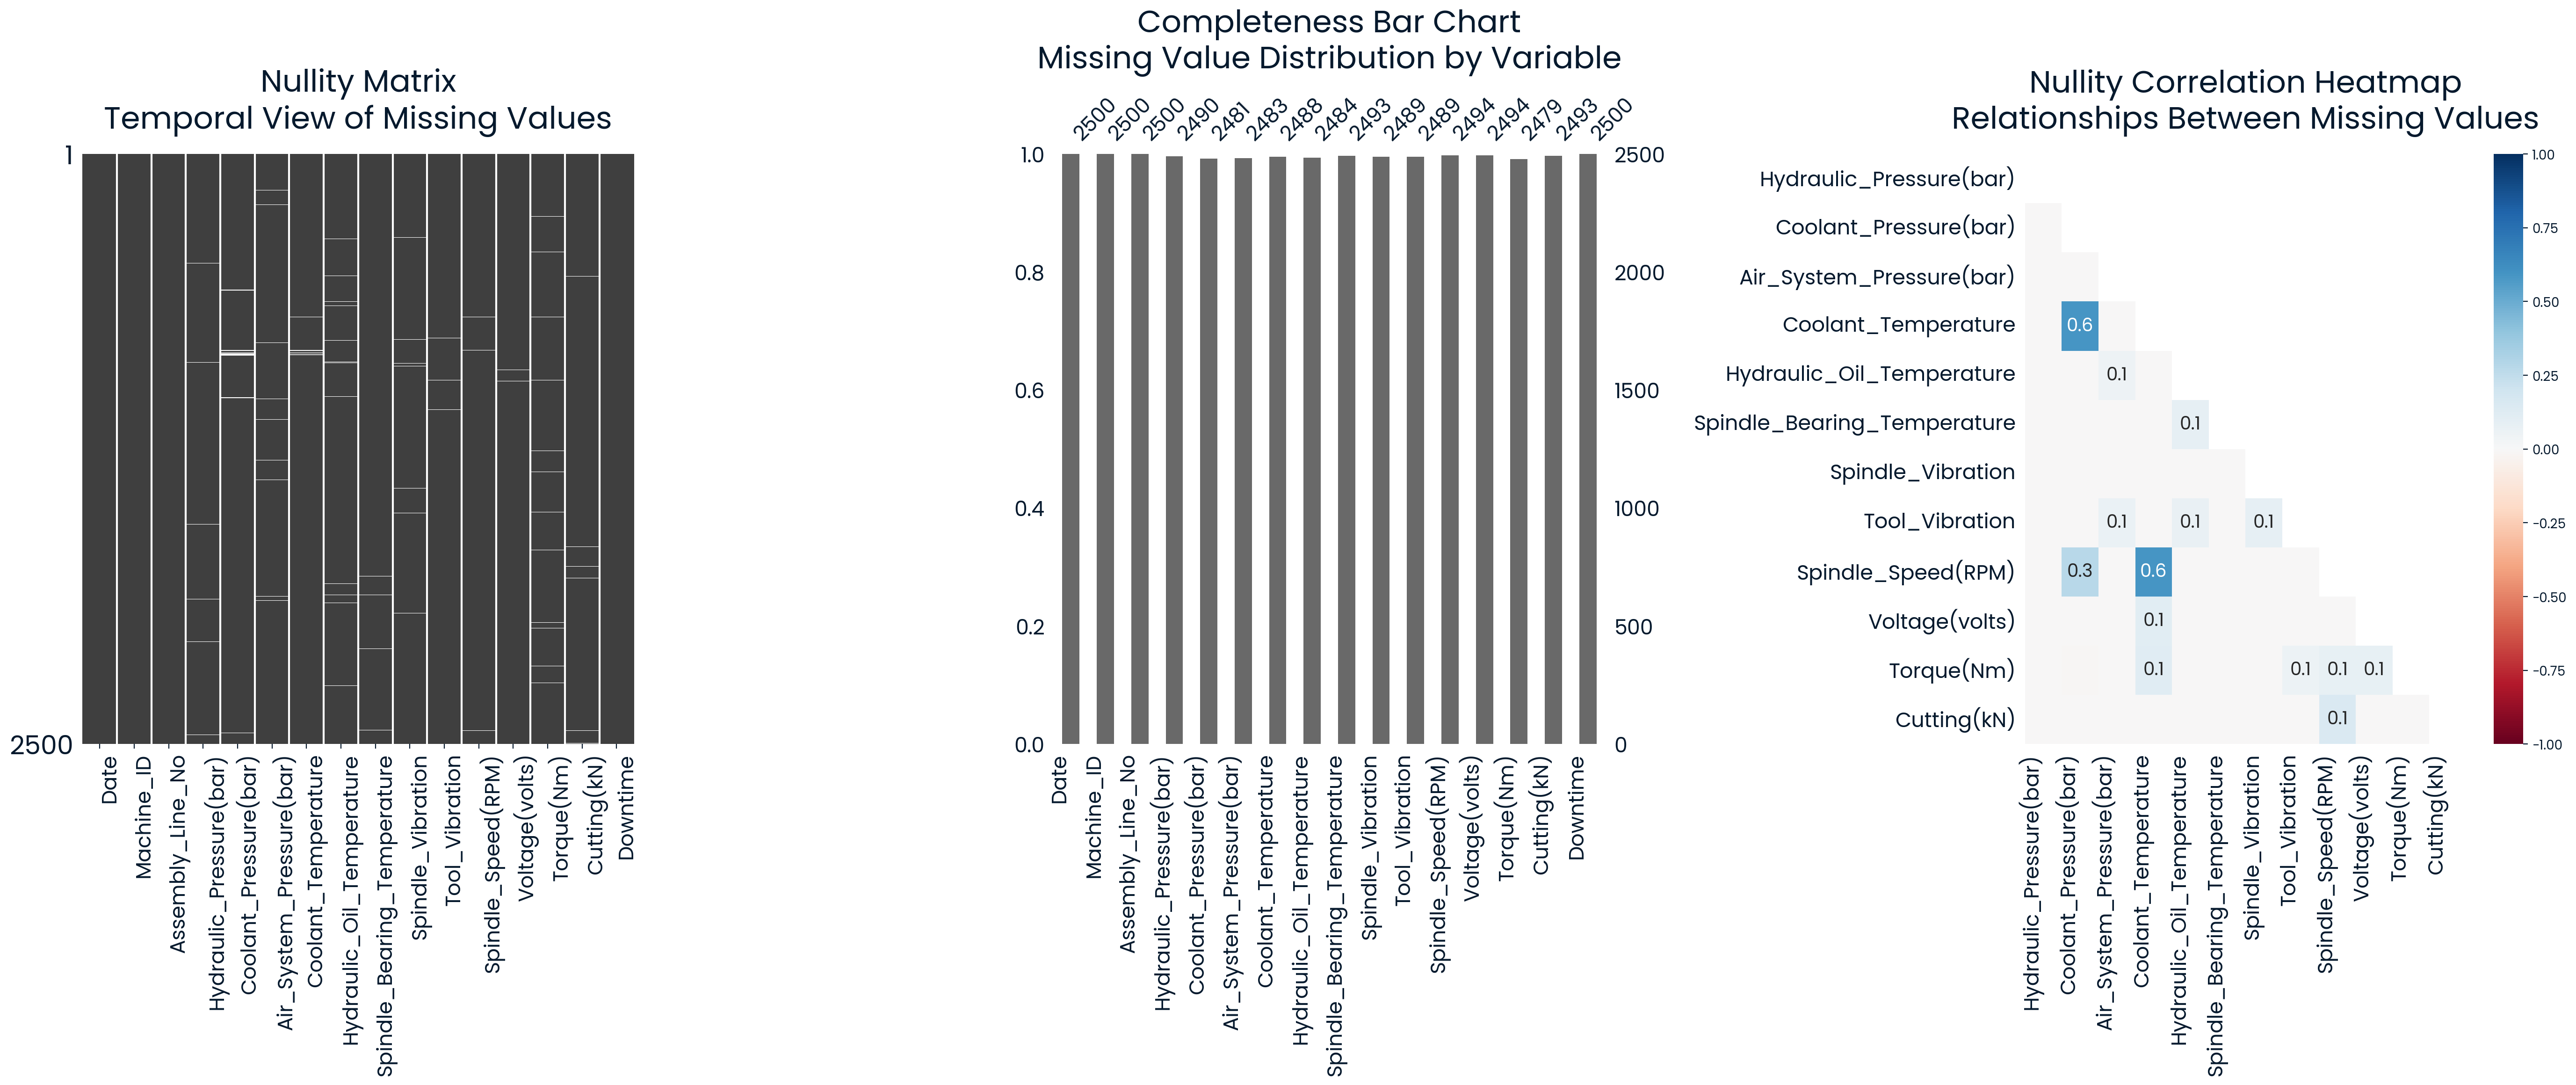

In [228]:
def missing_summary(data):
   """Generate professional missing data report"""
   # Overall statistics
   total_cells = data.size
   total_missing = data.isnull().sum().sum()
   missing_percentage = (total_missing / total_cells) * 100
   
   print("=== MISSING DATA ANALYSIS REPORT ===\n")
   
   print("OVERALL STATISTICS")
   print("-" * 50)
   print(f"Total Number of Data Points:     {total_cells:,}")
   print(f"Total Missing Values:            {total_missing:,}")
   print(f"Overall Missing Percentage:      {missing_percentage:.2f}%")
   
   # Variable-level analysis
   print("\nVARIABLE-LEVEL ANALYSIS") 
   print("-" * 50)
   
   # Create summary DataFrame
   missing_stats = pd.DataFrame({
       'Missing Count': data.isnull().sum(),
       'Missing %': (data.isnull().sum() / len(data) * 100).round(2)
   }).sort_values('Missing Count', ascending=False)
   
   # Only show variables with missing values
   missing_stats = missing_stats[missing_stats['Missing Count'] > 0]
   
   # Format for display
   print(missing_stats.to_string(float_format=lambda x: '{:.2f}'.format(x)))
   print(" ")

# Create visualization
fig = plt.figure(figsize=(28, 12))

# Matrix plot
ax0 = plt.subplot(1, 3, 1)
msno.matrix(data, ax=ax0)
ax0.xaxis.set_ticks_position('bottom')
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)
ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0)
ax0.set_title('Nullity Matrix\nTemporal View of Missing Values', 
             pad=20, fontsize=24)

# Bar plot
ax1 = plt.subplot(1, 3, 2)
msno.bar(data, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_title('Completeness Bar Chart\nMissing Value Distribution by Variable', 
             pad=20, fontsize=24)

# Heatmap
ax2 = plt.subplot(1, 3, 3)
msno.heatmap(data, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
ax2.set_title('Nullity Correlation Heatmap\nRelationships Between Missing Values', 
             pad=20, fontsize=24)

plt.tight_layout(pad=2.0)

# Generate summary before plots
missing_summary(data)

plt.show()

Let me break down what the following visualizations tell us about the machine sensor data in simple terms:

1. Overall Data Quality
- We have 40,000 total data points from various machine sensors
- Only 143 measurements are missing (0.36% of all data)
- This tells us the data collection system is working very well, with over 99% complete data

2. Missing Data Patterns (Matrix View - Left Plot)
- The white gaps show where data is missing
- These gaps appear scattered rather than clustered
- This random pattern suggests we're dealing with occasional sensor hiccups rather than systematic failures

3. Missing Values by Sensor (Bar Chart - Middle Plot)
- Torque measurements have the most gaps (21 missing readings)
- Followed by Coolant Pressure (19 missing) and Air System Pressure (17 missing)
- Most other sensors are missing fewer than 10 readings

4. Related Sensor Issues (Heatmap - Right Plot)
- The blue squares (0.6-0.8) show moderately strong relationships between missing values
- For example, when Coolant Temperature readings are missing, there's often missing data in Spindle Speed. This might indicate that certain sensor issues tend to happen together


**Given the high data quality and identified sensor relationships, we can proceed confidently with our objectives. The next step is to analyze how these sensor measurements relate to actual downtime events.**


## V. Analysis Report

### 1. What is the first and last date readings were taken on?

In [207]:
calendar_data = data.groupby('Date', as_index=False)['Machine_ID'].count()
fig = calplot(
   calendar_data,
   x="Date",
   y="Machine_ID",
   gap=1,
   colorscale='Aggrnyl',
   name='Machine ID Count',
   date_fmt='%d-%m-%Y'  # Ensure the date format is specified correctly
)
fig.update_layout(
   title={
       'text': 'Heatmap showing the number of machines monitored each day from Nov 24, 2021 to Jul 3, 2022<br>' +
               '<sup>The lighter the color, the higher count of machine checked</sup>',
       'y':0.90,
       'x':0.05,
       'xanchor': 'left',
       'yanchor': 'top',
       'font': {
           'size': 20,
           'color': 'black'  # Explicitly setting color to black
       }
   },
   height=400,
   margin=dict(t=100, b=20)
)
fig.show()

In [208]:
calendar_data = data[data['Downtime']=='Machine_Failure'].groupby('Date', as_index=False)['Machine_ID'].count()
fig = calplot(
   calendar_data,
   x="Date",
   y="Machine_ID",
   gap=1,
   colorscale='OrRd',
    date_fmt='%d-%m-%Y',  # Ensure the date format is specified correctly
   name='Machine ID Count'   
)
fig.update_layout(
   title={
       'text': 'Machine Failures Peak During Mid-Week of March-April 2022<br>' +
               '<sup>Calendar heatmap shows clustering of failures with darker shades indicating higher incident counts</sup>',
       'y':0.90,
       'x':0.05,
       'xanchor': 'left',
       'yanchor': 'top',
       'font': {
           'size': 20,
           'color': 'black'  # Explicitly setting color to black
       }
   },
   height=400,
   margin=dict(t=100, b=20)
)
fig.show()

Calendar visualizations reveals a critical pattern in machine failures from November 2021 to July 2022, with a notable concentration of incidents during March 2022. **The heatmap shows that weekdays experienced higher failure rates, particularly during mid-week periods. March stands out as a period of heightened concern, recording the highest frequency of machine downtimes.** This clustering of failures during specific weeks suggests potential systematic issues that may be tied to production schedules or maintenance cycles.

### 2. What is the average Torque?

In [209]:
# Get mean and median values
mean_torque = data['Torque(Nm)'].mean()
median_torque = data['Torque(Nm)'].median()

# If mean is greater than median (right-skewed)
if mean_torque > median_torque:
    intermediate_values = data.loc[(data['Torque(Nm)'] >= median_torque) & 
                                 (data['Torque(Nm)'] <= mean_torque)]
# If mean is less than median (left-skewed)
else:
    intermediate_values = data.loc[(data['Torque(Nm)'] >= mean_torque) & 
                                 (data['Torque(Nm)'] <= median_torque)]

# Display results
print(f"Mean Torque: {mean_torque:.2f}")
print(f"Median Torque: {median_torque:.2f}")
print(f"\nNumber of values between mean and median: {len(intermediate_values)}")
print(f"Percentage of total values: {(len(intermediate_values)/len(data))*100:.2f}%")

Mean Torque: 25.23
Median Torque: 24.65

Number of values between mean and median: 130
Percentage of total values: 5.20%


In [234]:
viz = Visualizer(color='#D3D3D3')
fig = viz.plot_histograms(data[data['Downtime']=='Machine_Failure'], title='', num_cols=3)
fig.update_layout(
   title={
       'text': 'Failed machines show peak torque at its mean,<br>with common ranges 13-19 Nm and 23-30 Nm<br>' +
               '<sup>Distributions of sensor values that experienced downtime</sup>',
       'y':0.93,
       'x':0.05,
       'xanchor': 'left',
       'yanchor': 'top',
       'font': {
           'size': 20,
           'color': 'black'
       }
   },
   height=600,
   margin=dict(t=140, b=40, l=20, r=20),
)

# To change color of Torque histogram specifically
for trace in fig.data:
    if 'Torque' in trace.name:
        trace.marker.color = '#006400'  # You can use any color code here

fig.show()

The torque distribution analysis uncovers a significant operational pattern centered around the **mean value of 25.23 Nm**, which appears to be a critical threshold in machine operation. This mean value serves as the peak point in the distribution, suggesting it's the most common operating state when machines fail. **The distribution reveals two distinct operational ranges: a lower cluster between 13-19 Nm and a higher cluster between 23-30 Nm.**

What makes this mean of 25.5 Nm particularly important is its position between these two clusters. When machines operate within either cluster, they show different failure characteristics. The lower range (13-19 Nm) might represent lighter operational loads, while the higher range (23-30 Nm) could indicate periods of increased mechanical stress. **The concentration of failures at the mean suggests this middle point might be a crucial transition zone where machines are particularly vulnerable to failure.**

### 3. Which assembly line has the highest readings of machine downtime?

In [211]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get failure counts
failure_data = data.groupby(['Assembly_Line_No', 'Downtime'], as_index=False)['Machine_ID'].count().query("Downtime == 'Machine_Failure'")

# Get total machine counts per assembly line
total_machines = data.groupby('Assembly_Line_No')['Machine_ID'].count().to_dict()

lines = failure_data['Assembly_Line_No'].tolist()
values = failure_data['Machine_ID'].tolist()  # failure counts
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Calculate percentages
percentages = [(value/total_machines[line])*100 for line, value in zip(lines, values)]

# Create subplots for three gauges
fig = make_subplots(
  rows=1, cols=3,
  specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]]
)

for idx, (line, value, color, pct) in enumerate(zip(lines, values, colors, percentages), 1):
  fig.add_trace(
      go.Indicator(
          mode="gauge+number",
          value=value,
          title={'text': f"{line} ({pct:.2f}%)", 'font': {'size': 14}},
          gauge={
              'axis': {'range': [0, total_machines[line]]},
              'bar': {'color': color},
              'bgcolor': "white",
              'borderwidth': 2,
              'bordercolor': "gray",
              'threshold': {
                  'line': {'color': "red", 'width': 4},
                  'thickness': 0.75,
                  'value': value
              }
          }
      ),
      row=1, col=idx
  )

fig.update_layout(
  title={
      'text': 'Shopfloor-1 has the most number of machine downtime. <br>' +
              '<sup>Gauge visualization reveals relative failure intensities</sup>',
      'y':0.90,
      'x':0.05,
      'xanchor': 'left',
      'yanchor': 'top',
      'font': {'size': 20, 'color': 'black'}
  },
  height=400,
  margin=dict(l=40, r=40)
)

fig.show()

**Shopfloor-L1 clearly emerges as the area with the highest machine downtime incidents.** The data shows 454 recorded failures, representing 51.95% of its total operational time. This rate notably exceeds both Shopfloor-L2 (396 failures, 49.01%) and Shopfloor-L3 (415 failures, 50.73%).

1. **All assembly lines show concerningly high failure rates around 50%**, suggesting a systemic issue in the manufacturing process. However, Shopfloor-L1's higher rate of 51.95% indicates it faces additional challenges.
2. The difference of 58 more failures in L1 compared to L2 (which has the lowest count) represents substantial lost production time and potential revenue loss.
3. The nearly 3% difference between L1 and L2's failure rates might seem small, but in high-precision manufacturing, this gap is meaningful and could indicate:
    - Different maintenance practices
    - Varying load distributions
    - Operational procedure variations


## Conclusion
The comprehensive analysis of machine monitoring data has successfully addressed all three primary objectives, providing clear insights for maintenance optimization. The temporal analysis established a complete monitoring timeline from November 24, 2021, to July 3, 2022, revealing critical patterns in machine failures, particularly during mid-week periods of March 2022. This temporal insight enables more strategic scheduling of preventive maintenance to address peak failure periods.

The torque analysis uncovered a significant operational pattern centered on the mean value of 25.23 Nm, which serves as a critical threshold in machine operation. The identification of two distinct operational ranges (13-19 Nm and 23-30 Nm) provides clear parameters for monitoring and intervention. This understanding of torque behavior offers a concrete basis for developing early warning systems and operational guidelines to prevent failures during critical transitions between these ranges.

In examining assembly line performance, Shopfloor-L1 emerged as the most problematic area with 454 failures, representing a 51.95% downtime rate. This notably exceeds both Shopfloor-L2 (396 failures, 49.01%) and Shopfloor-L3 (415 failures, 50.73%). The consistent pattern of approximately 50% failure rates across all lines indicates a systemic issue requiring comprehensive intervention, with particular attention needed for Shopfloor-L1's operational procedures and maintenance protocols.

## Actionable Recommendations

These recommendations are based on clear data patterns and focus on practical, implementable solutions that address the identified issues while considering manufacturing realities and resource constraints.

**1. Maintenance Schedule Optimization**
- Implement staggered maintenance during identified peak failure periods (mid-week, March)
- Schedule major preventive maintenance before high-risk periods
- Develop backup capacity planning for March operations
Measurable outcome: 20% reduction in mid-week failures within 3 months

**2. Torque Management Protocol**
- Install continuous torque monitoring systems focusing on the 23-30 Nm range
- Establish alert protocols when torque approaches 25.23 Nm
- Develop response procedures for transitions between torque ranges
Measurable outcome: 15% reduction in torque-related failures within 6 months

**3. Assembly Line Standardization**
- Audit Shopfloor-L1 maintenance practices and align with better-performing lines
- Implement load balancing across assembly lines
- Standardize operational procedures across all shifts
Measurable outcome: Reduce variance in failure rates between lines to below 2% within 6 months

> **By implementing these data-driven insights, the company can move beyond the traditional reactive approach to a more sophisticated, predictive maintenance strategy that will reduce downtime, optimize resource allocation, and improve overall operational efficiency.**